# Statistical Methods in Image Processing EE-048954
## Homework 3: Contrastive Divergence and Noise Contrastive Estimation
### Due Date: <span style="color:red">June 16, 2022</span>

###  Submission Guidelines

* Submission only in **pairs** on the course website (Moodle).
* Working environment:
    * We encourage you to work in `Jupyter Notebook` online using <a href="https://colab.research.google.com/">Google Colab</a> as it does not require any installation.
* You should submit two **separated** files:
    * A `.ipynb` file, with the name: `ee048954_hw3_id1_id2.ipynb` which contains your code implementations.
    * A `.pdf` file, with the name: `ee048954_hw3_id1_id2.pdf` which is your report containing plots, answers, and discussions.
    * **No handwritten submissions** and no other file-types (`.docx`, `.html`, ...) will be accepted.

### Mounting your drive for saving/loading stuff

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

### Importing relevant libraries

In [502]:
## Standard libraries
import os
import math
import time
import numpy as np
import random
import copy

## Scipy optimization routines
from scipy.optimize import minimize

## Progress bar
import tqdm

## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
plt.style.use('ggplot')

## Part I: Contrastive Divergence (50 points)

Consider the following Gaussian Mixture Model (GMM) distribution

$$ p(x;\{\mu_i\}) = \sum_{i=1}^{N}\frac{1}{N}\,\frac{1}{{{2\pi}}} \exp\left\{-\frac{1}{2}||x-\mu_i||^2\right\} ,$$	
where $x,\mu_i \in \mathbb{R}^2$. We will use $N = 4$, $\sigma = 1$, and $\{\mu_i\} = \{(0,0)^T , (0,3)^T , (3,0)^T , (3,3)^T\}$.

#### Sampling from GMM

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 1</span>**. Direct sampling: Use your function from HW1 that accepts $\{\mu_i\}$, and returns a sample $x$ from $p(x;\{\mu_i\})$. Draw $J=1000$ samples $\{x\}$ from the distribution $p(x;\{\mu_i\})$ using this function. These will be our **real samples**.

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 2</span>**. Sampling with MCMC: implement the MALA algorithm to draw samples from $p(x;\{\mu_i\})$. The function will get an initial guess $\{\hat x_i\}$ and will generate chains of length $L$. Use $\sqrt{2\varepsilon} = 0.1$ and $N \sim \mathcal{N}(0,I)$.

**From now on**, we will refer to **$\{\mu_i\}$ as unknowns** and we will estimate them using different algorithms.

In [503]:
#Task 1
from scipy.stats import multivariate_normal as mv_normal
import torch
def sample_from_gaussian_mixture(M,sigma_2,miu_m,N):
    """
    Sample Gaussian Mixture
    :param M: num of gaussians
    :param sigma: variance
    :param miu_m: 
    :param N: num of samples
    :return:
    """
    sigma_2 = np.eye(2)*sigma_2
    gauss_components = np.random.choice(M, N ,replace=True)# sample N gaussian components
    xs= np.array([np.random.multivariate_normal(miu,sigma_2) for miu in miu_m[gauss_components]])
    #pdf = 0
    #for miu in miu_m:
    #    pdf+=mv_normal.pdf(xs,miu,sigma)
    return torch.tensor(xs)



In [504]:
torch.manual_seed(0)
N=4
sigma=1
miu_m = torch.tensor([[0,0],[0,3],[3,0],[3,3]])
J=1000
real_samples = sample_from_gaussian_mixture(N,sigma,miu_m,J)

In [505]:
#Task 2
# task 8
import torch
def log_prob_grad(x,mus,sigma_2):
    sum_num = 0
    sum_denom = 0
    for mu in mus:
        #print(x.shape)
        #print(mu.shape)
        exp_arg = torch.exp(-(2*sigma_2)**(-1)*torch.norm(x-mu,dim=1)**2)
        sum_num += ((x-mu).T* exp_arg)
        sum_denom +=exp_arg
        
    grad = -(sigma_2)**(-1)*sum_num/sum_denom
    #print('grad shape' , grad.shape)
    return grad.T
    
    
def q_x_prime_given_x(x_prime,x,grad_log_x,eps):
    q = torch.exp(-1/(4*eps)*torch.norm(x_prime-x-eps*grad_log_x)**2)
    return q

def MALA_update(x_k,p_x_k,grad_x_k,sqrt_two_eps,mus,sigma_2):
    eps = sqrt_two_eps**2/2
    ### Check acceptance criteria:
    #norm = normal.MultivariateNormal(torch.zeros(image_size,image_size),torch.eye(image_size))
    samples = torch.randn((len(x_k),2))#.to(device)
    #print("sa",samples.shape)
    #print("gra",grad_x_k.shape)
    #print("x_k",x_k.shape)
    x_k_plus_1 = x_k + ((sqrt_two_eps**2)/2)*grad_x_k + sqrt_two_eps * samples
    p_x_k_plus_1 = pdf_gaussian_mixture(x_k_plus_1,mus,sigma)
    grad_x_k_plus_1 = log_prob_grad(x_k,mus,sigma_2)

    is_accepted = p_x_k_plus_1>p_x_k
    only_accepted_x_k_plus_1 = x_k_plus_1[is_accepted]
    not_accepted_x_k_plus_1 = x_k_plus_1[~is_accepted]
    
    ### replace x_k_plus_1 with x_k with probability alpha:
    if len(not_accepted_x_k_plus_1)>0:
        
        q_x_k_given_x_k_plus_1 = q_x_prime_given_x(x_k,x_k_plus_1,grad_x_k_plus_1,eps)
        q_x_k_plus_1_given_x_k = q_x_prime_given_x(x_k_plus_1,x_k,grad_x_k,eps)
        
        alpha = p_x_k_plus_1*q_x_k_given_x_k_plus_1/(p_x_k*q_x_k_plus_1_given_x_k)
        alpha_not_accepted = alpha[~is_accepted]
        
        u = torch.rand(len(not_accepted_x_k_plus_1))#.to(device)
        
        is_accepted_after_MALA =  ( u<=alpha_not_accepted )
        
        accepted_after_MALA_x_k_plus_1 = not_accepted_x_k_plus_1[is_accepted_after_MALA]
        x_k_remain_after_MALA = (x_k[~is_accepted])[~is_accepted_after_MALA]
        #print(len(accepted_after_MALA_x_k_plus_1) ,' were accepted after MALA')
        #not_accepted_after_MALA = not_accepted[~is_accepted_after_MALA]
        x_k_plus_1_final = torch.concat((only_accepted_x_k_plus_1,accepted_after_MALA_x_k_plus_1,x_k_remain_after_MALA))
    else:
        #print('all accepted')
        x_k_plus_1_final = x_k_plus_1 # all samples got updated.
        
    return x_k_plus_1_final

def pdf_gaussian_mixture(x,mus,sigma_2):
    pdf = 0
    for mu in mus:
        pdf+=mv_normal.pdf(x,mu,sigma_2)
    return torch.tensor(pdf/len(mus))
                                       
# number of images to generate
def ld_with_MALA(L,sqrt_two_eps,init_samples,mus,sigma_2):
    """
    Sample with MALA
    :L: chain length
    :sqrt_two_eps:
    :init_samples: initial guess
    :mus: expectation of gaussian mixture
    """
    x_k = init_samples
    eps = (sqrt_two_eps**2)/2
    # norm = normal.MultivariateNormal(torch.zeros(image_size,image_size),torch.eye(image_size))
    p_x_k = pdf_gaussian_mixture(x_k,mus,sigma_2)
    grad_x_k = log_prob_grad(x_k,mus,sigma_2)
    
    for l in range(L):
        # run the model: input the images x, getting as output their estimated energy E(x)
        x_k= MALA_update(x_k,p_x_k,
                         grad_x_k,
                         sqrt_two_eps,
                         mus,
                         sigma_2
                        )
        p_x_k = pdf_gaussian_mixture(x_k,mus,sigma_2)
        grad_x_k = log_prob_grad(x_k,mus,sigma_2)

        #if (l%200 == 0):
        #   print('MALA: Iteration {0} completed'.format(l))
        #_all_x.append(x_k[0])
    return x_k


#### Estimation of $\{\mu_i\}$

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 3</span>**. Implement Maximum likelihood (ML) estimation of $\{\mu_i\}$ using direct sampling:
* Step 1: Randomly initialize $\{\tilde \mu_i\}$ from $U([0,3]^2)$.
* Step 2: Use your function from Task 1 to draw 100 samples ${\tilde x}$ from $p(x;\{\mu_i\})$ using $\{\tilde \mu_i\}$.
* Step 3: Update $\{\tilde \mu_i\}$ using the ML gradient descent step:
$$ \tilde \mu_i ^ {k+1} = \tilde \mu_i ^ {k} + \eta\left(\langle \nabla_{\mu_i} \log p(x;\{\mu_i\})\rangle_{x}-\langle \nabla_{\mu_i} \log p(x;\{\mu_i\})\rangle_{\tilde x}\right),$$
where $\langle\cdot\rangle_x$ denotes averaging over the real samples from Task 1 and $\langle\cdot\rangle_{\tilde x}$ denotes averaging over the synthetically generated samples from Step 2. Use $\eta = 1$.
* Repeat Step 2 and Step 3 until convergence.

In [506]:
def log_prob_grad_mu(x,mus,sigma_2):
    N = len(mus)
    sum_num = 0
    sum_denom = 0
    #for i,mu in enumerate(mus):
        #exp_arg[i,:] = torch.exp(-(2*sigma_2)**(-1)*torch.norm(x-mu,dim=1)**2)
    mus= mus.reshape(N,1,2)
    exp_args = torch.exp(-(2*sigma_2)**(-1)*torch.norm(x-mus,dim=2)**2)
    sum_denom = torch.sum(exp_args,dim=0)
    grad = (sigma_2)**(-1)*exp_args*((x-mus).permute(2,0,1))/sum_denom
    mus = mus.reshape(N,2)

    #print('grad sum' , torch.sum(grad))
    return grad.permute(1,2,0)

eta = 1
N=4 #num of mus
mus_init_guess = torch.rand(N,2)*3.
sqrt_two_eps = 0.1
num_of_samples = 100
#init_samples = torch.rand(num_of_samples,2)
#x_tilda = ld_with_MALA(L,sqrt_two_eps,init_samples,mus_init_guess,sigma)
sigma_2 = 1
mus = mus_init_guess
max_iteration = 1000

prev_mus=0
diff = []
for i in range(max_iteration):
    x_tilda = sample_from_gaussian_mixture(N,sigma_2,mus,num_of_samples)
    mus = mus + eta*(torch.mean(log_prob_grad_mu(real_samples,mus,sigma_2),dim=1)-torch.mean(log_prob_grad_mu(x_tilda,mus,sigma_2),dim=1))
    diff.append(torch.norm(prev_mus - mus))
    if torch.norm(prev_mus - mus)< 0.05:
        break
    prev_mus = mus
    if (i%200 == 0):
        print('MLE: Iteration {0}'.format(i))


print(mus)
mus_ML = mus
x_tilda_ML = x_tilda

MLE: Iteration 0
MLE: Iteration 200
MLE: Iteration 400
MLE: Iteration 600
tensor([[ 2.8273, -0.1956],
        [-0.0231,  0.1211],
        [ 0.0135,  3.0833],
        [ 3.1814,  2.8486]], dtype=torch.float64)


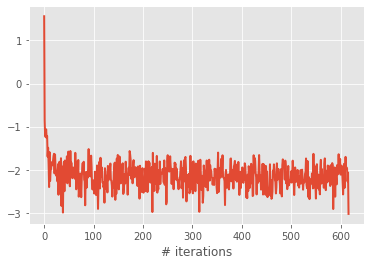

In [507]:
from matplotlib import pyplot as plt
diff = torch.tensor(diff)
plt.plot(torch.log(diff))
plt.xlabel("# iterations")
plt.savefig("Task_3_ML_log_norm_diff")

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 4</span>**. Implement Maximum likelihood (ML) estimation of $\{\mu_i\}$ using MCMC:
* Step 1: Randomly initialize $\{\tilde \mu_i\}$ from $U([0,3]^2)$.
* Step 2: Use your function from Task 2 to draw 100 samples ${\tilde x}$ from $p(x;\{\mu_i\})$ using $\{\tilde \mu_i\}$. Initialize the chains with $\hat x_i \sim \mathcal{N}(1.5,2)$ and use chains length of $L=1000$.
* Step 3: Update $\{\tilde \mu_i\}$ using the ML gradient descent step:
$$ \tilde \mu_i ^ {k+1} = \tilde \mu_i ^ {k} + \eta\left(\langle \nabla_{\mu_i} \log p(x;\{\mu_i\})\rangle_{x}-\langle \nabla_{\mu_i} \log p(x;\{\mu_i\})\rangle_{\tilde x}\right),$$
where $\langle\cdot\rangle_x$ denotes averaging over the real samples from Task 1 and $\langle\cdot\rangle_{\tilde x}$ denotes averaging over the synthetically generated samples from Step 2. Use $\eta = 1$.
* Repeat Step 2 and Step 3 until convergence.

In [508]:
torch.manual_seed(0)
### define parameters for MCMC samples ###
sigmax_tilda= torch.tensor(2)
mu_x = torch.tensor(1.5)
L=1000
num_of_samples = 100
sqrt_two_eps = 0.1
x_tilda = torch.randn(num_of_samples,2)*torch.sqrt(sigma_2_x) + mu_x #initial guess for chain
# gaussian mixture params:
sigma_2 = 1
mus = torch.rand(N,2)*3. # initial guess for mus
######################################

### define parameters for ML estimation ###
max_iteration =1000
######################################

### Run until convergence ###
diff = []
for i in range(max_iteration):
    x_tilda = ld_with_MALA(L,sqrt_two_eps,x_tilda,mus,sigma_2)
    mus = mus + eta*(torch.mean(log_prob_grad_mu(real_samples,mus,sigma_2),dim=1)-torch.mean(log_prob_grad_mu(x_tilda,mus,sigma_2),dim=1))
    diff_i = torch.norm(prev_mus - mus)
    diff.append(diff_i)
    print("Loss: " , diff_i)

    if diff_i < 0.05:
        print("Loss: " , loss_i)
        break
    prev_mus = mus
    if (i%200 == 0):
           print('MLE: Iteration {0}'.format(i))
print(mus)
mus_ML_MCMC = mus
x_tilda_ML_MCMC = x_tilda

Loss:  tensor(4.5929, dtype=torch.float64)
MLE: Iteration 0
Loss:  tensor(0.4135, dtype=torch.float64)
Loss:  tensor(0.3430, dtype=torch.float64)
Loss:  tensor(0.2960, dtype=torch.float64)
Loss:  tensor(0.2699, dtype=torch.float64)
Loss:  tensor(0.2028, dtype=torch.float64)
Loss:  tensor(0.1726, dtype=torch.float64)
Loss:  tensor(0.1722, dtype=torch.float64)
Loss:  tensor(0.1570, dtype=torch.float64)
Loss:  tensor(0.1160, dtype=torch.float64)
Loss:  tensor(0.0837, dtype=torch.float64)
Loss:  tensor(0.0798, dtype=torch.float64)
Loss:  tensor(0.1043, dtype=torch.float64)
Loss:  tensor(0.1159, dtype=torch.float64)
Loss:  tensor(0.1204, dtype=torch.float64)
Loss:  tensor(0.1012, dtype=torch.float64)
Loss:  tensor(0.1074, dtype=torch.float64)
Loss:  tensor(0.0866, dtype=torch.float64)
Loss:  tensor(0.0612, dtype=torch.float64)
Loss:  tensor(0.0921, dtype=torch.float64)
Loss:  tensor(0.0945, dtype=torch.float64)
Loss:  tensor(0.0456, dtype=torch.float64)
Loss:  tensor(0.0456, dtype=torch.flo

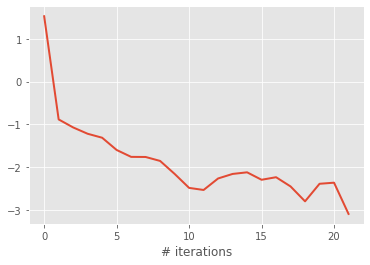

In [509]:
from matplotlib import pyplot as plt
diff = torch.tensor(diff)
plt.plot(torch.log(diff))
plt.xlabel("# iterations")
plt.savefig("Task_4_ML_log_norm_diff")

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 5</span>**. Implement Contrastive Divergence (CD) estimation of $\{\mu_i\}$ using MCMC sampling:
* Step 1: Randomly initialize $\{\tilde \mu_i\}$ from $U([0,3]^2)$.
* Step 2: Use your function from Task 2 to draw 100 samples ${\tilde x}$ from $p(x;\{\mu_i\})$ using $\{\tilde \mu_i\}$. Initialize the chains with **100 samples randomly chosen from the real set of examples from Task 1**, and use only $L=10$ update steps.
* Step 3: Update $\{\tilde \mu_i\}$ using the CD gradient descent step:
$$ \tilde \mu_i ^ {k+1} = \tilde \mu_i ^ {k} + \eta\left(\langle \nabla_{\mu_i} \log p(x;\{\mu_i\})\rangle_{x}-\langle \nabla_{\mu_i} \log p(x;\{\mu_i\})\rangle_{\tilde x}\right),$$
where $\langle\cdot\rangle_x$ denotes averaging over the $100$ real samples used for initialization of the chains in Step 2 and $\langle\cdot\rangle_{\tilde x}$ denotes averaging over the MCMC generated samples from Step 3. Use $\eta = 1$.
* Repeat Step 2 and Step 3 until convergence.

In [523]:
torch.manual_seed(0)
### define parameters for MCMC samples ###
L=10
num_of_samples = 100
sqrt_two_eps = 0.1
# gaussian mixture params:
sigma_2 = 1
mus = torch.rand(N,2)*3. # initial guess for mus
######################################

### define parameters for ML estimation ###
max_iteration = 1000
######################################

### Run until convergence ###
diff = []
prev_mus = 0
for i in range(max_iteration):
    x_init_guess = real_samples[np.random.choice(num_of_samples,num_of_samples)]
    x_tilda = ld_with_MALA(L,sqrt_two_eps,x_init_guess,mus,sigma_2)
    mus = mus + eta*(torch.mean(log_prob_grad_mu(real_samples,mus,sigma_2),dim=1)-torch.mean(log_prob_grad_mu(x_tilda,mus,sigma_2),dim=1))
    diff_i = torch.norm(prev_mus - mus)
    diff.append(diff_i)
    if loss_i < 0.05:
        print("diff: ", diff_i)
        break
    prev_mus = mus
    if (i%200 == 0):
           print('MLE: Iteration {0}'.format(i))
print(mus)
mus_CD = mus
x_tilda_CD = x_tilda

MLE: Iteration 0
Loss:  tensor(0.0461, dtype=torch.float64)
tensor([[-0.2636,  0.0869],
        [ 2.1689, -2.0325],
        [-1.6397,  2.7729],
        [-0.4488,  3.6862]], dtype=torch.float64)


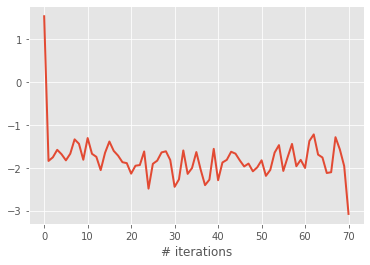

In [524]:
from matplotlib import pyplot as plt
diff = torch.tensor(diff)
plt.plot(torch.log(diff))
plt.xlabel("# iterations")
plt.savefig("Task_5_ML_log_norm_dif")

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 6</span>**.
Present the estimated $\{\mu_i\}$ and the final random samples $\{\tilde x_i\}$ generated with each of the three algorithms in Tasks 3-5. Discuss the differences in convergence.

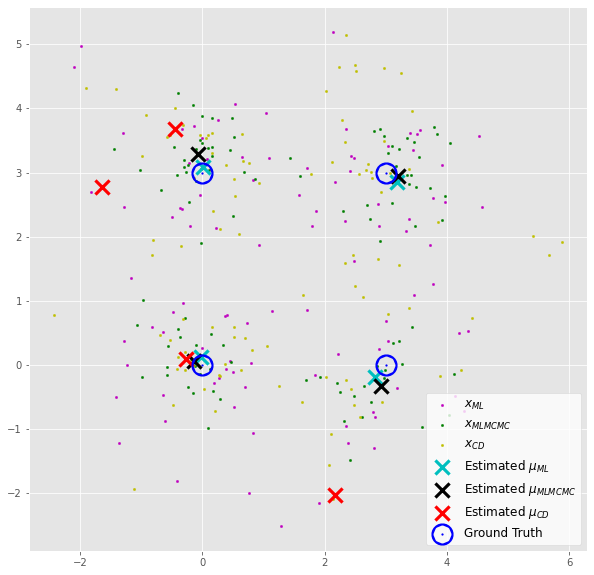

In [545]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10,10))
plt.scatter(x_tilda_ML[:,0],x_tilda_ML[:,1],s=5,c='m')
plt.scatter(x_tilda_ML_MCMC[:,0],x_tilda_ML_MCMC[:,1],s=5,c='g')
plt.scatter(x_tilda_CD[:,0],x_tilda_CD[:,1],s=5,c='y')

plt.scatter(mus_ML[:,0],mus_ML[:,1],marker='x',s=5,linewidth=20,c='c')
plt.scatter(mus_ML_MCMC[:,0],mus_ML_MCMC[:,1],marker='x',s=5,linewidth=20,c='k')
plt.scatter(mus_CD[:,0],mus_CD[:,1],marker='x',s=5,linewidth=20,c='r')
plt.scatter(miu_m[:,0],miu_m[:,1],marker='o',s=5,linewidth=20,c='b')
plt.legend(('$x_{ML}$','$x_{ML MCMC}$','$x_{CD}$','Estimated ${\mu}_{ML}$','Estimated ${\mu}_{MLMCMC}$','Estimated ${\mu}_{CD}$',
            'Ground Truth'),loc='lower right',facecolor='w', prop={'size': 12})

plt.savefig("Task_6_results")

## Part II: Noise Contrastive Estimation (50 points)

Consider the distribution
$$p_m(x;\{\mu_i\}) = \frac{1}{Z} \sum_{i=1}^{N} \exp\left\{-\frac{1}{2\sigma^2}||x-\mu_i||^2\right\} ,$$	
where $Z \in \mathbb{R}$ is a normalization constant, and $ x,\mu_i \in \mathbb{R}^2$.

#### Sampling from GMM

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 7</span>**. What is the value of $Z$?

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 8</span>**. Use $N = 4$, $\sigma = 1$, and $\{\mu_i\} = \{(0,0)^T , (0,3)^T , (3,0)^T , (3,3)^T\} $. Draw $J=1000$ samples $\{x_j\}$ from the distribution $p_m(x;\{\mu_i\})$ using the function from Task 1.

**From now on**, we will refer to **$\{\mu_i\}$ as unknowns** and we will estimate them using the Noise Contrastive Estimation method.

In [567]:
#task 7+8
N=4
sigma_2=1
miu_m = torch.tensor([[0,0],[0,3],[3,0],[3,3]])
J=1000

Z_real = 2*np.pi*N*sigma_2
print('Real Z:' , Z_real)
real_samples = sample_from_gaussian_mixture(N,sigma_2,miu_m,J)

Real Z: 25.132741228718345


#### Estimation of $\{\mu_i\}$

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 9</span>**. Implement Noise Contrastive Estimation of $\{\mu_i\}$:
* Step 1: Generating the artificial data-set of noise: Draw $J=1000$ samples $\{y_j\}$ from $$p_n(y;\mu_n) = \frac{1}{{{2\pi \sigma_n^2}}} \exp\left\{-\frac{1}{2\sigma_n^2}||y-\mu_n||^2\right\}$$
  using $\mu_n = (1,1)^T$ and $\sigma_n=2$.
* Step 2: Randomly select an initial guess for the model means $\{\tilde \mu_i\}$ from $U([0,3]^2)$.
* Step 3: Update $\{\tilde \mu_i\}$ by **maximizing**:
$$\{\tilde \mu_i\} = \underset{\{\mu_i\}}{\arg\max} \, \sum_{j=1}^{J} \left[\ln (h(x_j;\{\mu_i\})) + \ln(1-h(y_j;\{\mu_i\})) \right],$$
where
$$h(u;\{\mu_i\}) = \frac{p_m(u;\{\mu_i\})}{p_m(u;\{\mu_i\})+p_n(u;\mu_n)}.$$
  Implementation Tip: This step can be executed using the function `scipy.optimize.minimize` which finds the **minimum** of an (unconstrained) optimization problem (e.g. using the `'BFGS'` method), given a function that calculates the objective and an initial guess (see scipy documentation for more details). In our case, for **maximization**, implement a function that calculates the **minus** of the objective above.

In [552]:
import scipy
torch.manual_seed(0)
def p_m_pdf(u,mus,sigma_2):
    pdf = 0
    mus = mus.reshape(4,2)
    for miu in mus:
        pdf+=mv_normal.pdf(u,miu,sigma_2)
    return pdf/(len(mus)*2*np.pi*sigma_2)

def p_n_pdf(u,mu_n,sigma_n_2):
    return mv_normal.pdf(u, mu_n , sigma_n_2)

def h(u,mus,mu_n,sigma_n_2,sigma_2):
    p_m = p_m_pdf(u, mus, sigma_2)
    p_n = p_n_pdf(u,mu_n,sigma_n_2)
    h_i = p_m/(p_m+p_n)
    return h_i

def func_to_optim_task_9(mus,x,y,mu_n,sigma_n_2,sigma_2):
    s = -np.sum(np.log(h(x,mus,mu_n,sigma_n_2,sigma_2))+np.log(1-h(y,mus,mu_n,sigma_n_2,sigma_2)))
    return s

# def task_9(J):
#     """
#     task_9 - Noise Contrastive Estimation with un-normalized model
#     :param J: num of samples
#     :return:
#     """

### define params for p_m
mus_initial_guess_task_9 = torch.rand(N,2)*3. # initial guess for mus
mus = mus_initial_guess_task_9

###  define params for samples y:
J=1000
mu_n = torch.tensor([1.,1.])
sigma_n = 2
sigma_n_2 = sigma_n**2
num_of_samples= J #num of samples
samples_y_task_9 = mv_normal.rvs(mu_n,sigma_n_2,num_of_samples)
samples_y = samples_y_task_9

x = real_samples
y = samples_y

res = scipy.optimize.minimize(func_to_optim_task_9,mus,(x,y,mu_n,sigma_n_2,sigma_2))
mus_task_9 = res['x'].reshape(4,2)
    #return mus_task_9
print('mus:\n', mus_task_9)


mus:
 [[ 2.79897338e+00 -1.21866432e-01]
 [-5.29637166e-02 -2.08203578e-03]
 [-3.81547730e-02  3.02484410e+00]
 [ 3.06992562e+00  2.90162442e+00]]


We will now regard both $\{\mu_i\}$ **and the normalization constant $Z$** as unknowns, and will estimate them using Noise Contrastive

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 10</span>**. Implement Noise Contrastive Estimation with an **un-normalized** probability model:
* Step 1: Generating the artificial data-set of noise: Draw $J=1000$ samples $\{y_j\}$ from $$p_n(y;\mu_n) = \frac{1}{{{2\pi \sigma_n^2}}} \exp\left\{-\frac{1}{2\sigma_n^2}||y-\mu_n||^2\right\}$$
  using $\mu_n = (1,1)^T$ and $\sigma_n=2$.
* Step 2: Randomly select an initial guess for the model means $\{\tilde \mu_i\}$ from $U([0,3]^2)$, and for the normalization constant $Z$ from $U([0.1,1])$
* Step 3: Update $\{\tilde \mu_i\}$ and $Z$ by **maximizing**:
$$\{\tilde \mu_i\}, Z = \underset{\{\mu_i\}, Z}{\arg\max} \, \sum_{j=1}^{J} \left[\ln (h(x_j;\{\mu_i\}, Z)) + \ln(1-h(y_j;\{\mu_i\}, Z)) \right],$$
where
$$h(u;\{\mu_i\}, Z) = \frac{p_m(u;\{\mu_i\}, Z)}{p_m(u;\{\mu_i\}, Z)+p_n(u;\mu_n)}.$$

In [566]:
torch.manual_seed(1)
def p_m_pdf_z(u,mus,sigma_2,Z):
    pdf = 0
    mus = mus.reshape(4,2)
    for miu in mus:
        pdf+=np.exp(-1/(2*sigma_2)*np.linalg.norm(u-miu,axis=1)**2)
    return pdf/Z

def h_z(u,mus,mu_n,sigma_n_2,Z):
    p_m = p_m_pdf_z(u, mus, sigma_2,Z)
    p_n = p_n_pdf(u,mu_n,sigma_n)
    h_i = p_m/(p_m+p_n)
    return h_i

def func_to_optim_task_10(params,x,y,mu_n,sigma_n_2):
    #parse params
    mus = params[0:8].reshape(4,2)
    Z = params[8]
    s = -np.sum(np.log(h_z(x,mus,mu_n,sigma_n_2,Z))+np.log(1-h_z(y,mus,mu_n,sigma_n_2,Z)))
    return s

# def task_10(J):
#     """
#     task_10 - Noise Contrastive Estimation with un-normalized model
#     :param J: num of samples
#     :return:
#     """


###  define params for samples y (artificial noise):
J=1000
mu_n = torch.tensor([1.,1.])
sigma_n = 2
sigma_n_2 = sigma_n**2
num_of_samples= J 
samples_y_task_10 =  mv_normal.rvs(mu_n,sigma_n_2,num_of_samples)
samples_y = samples_y_task_10

### define params for p_m
mus_initial_guess_task_10 = torch.rand(N,2)*3. # initial guess for mus
mus = mus_initial_guess_task_10
Z = torch.rand(1)*(1-0.1)+0.1
sigma_2 = 1

x = real_samples
y = samples_y

params = torch.concat((mus.reshape(8),Z))
res = scipy.optimize.minimize(func_to_optim_task_10,params,(x,y,mu_n,sigma_n_2))
mus_task_10 = res['x'][0:8].reshape(4,2)
Z = res['x'][8]

print('mus:\n' ,mus_task_10)
print('Z:\n', Z)
#return mus_task_10, Z

mus:
 [[2.2408676  0.10317714]
 [2.48896554 2.33194194]
 [0.0861735  0.30610871]
 [0.21117976 2.50966353]]
Z:
 26.55010667945897


#### Evaluating the Results

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 11</span>**. Visually: plot the estimates of $\{\mu_i\}$ of Tasks 9 and 10 (two separate figures). Include the model samples, the noise samples, the initial guess for the model means, and the final estimates of $\{\tilde \mu_i\}$.

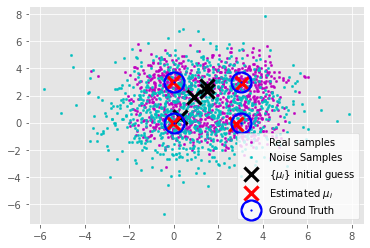

In [568]:
from matplotlib import pyplot as plt

fig = plt.figure()
plt.scatter(real_samples[:,0],real_samples[:,1],s=5,c='m')
plt.scatter(samples_y_task_9[:,0],samples_y_task_9[:,1],s=5,c='c')
plt.scatter(mus_initial_guess_task_9[:,0],mus_initial_guess_task_9[:,1],marker='x',s=5,linewidth=20,c='k')
plt.scatter(mus_task_9[:,0],mus_task_9[:,1],marker='x',s=5,linewidth=20,c='r')
plt.scatter(miu_m[:,0],miu_m[:,1],marker='o',s=5,linewidth=20,c='b')
plt.legend(('Real samples','Noise Samples','{$\mu_i$} initial guess','Estimated ${\mu_i}$','Ground Truth'),loc='lower right',facecolor='w')


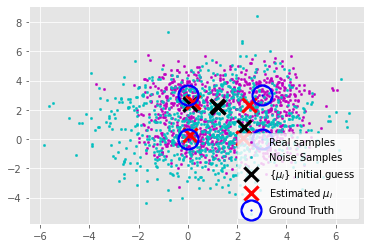

In [569]:
fig = plt.figure()
plt.scatter(real_samples[:,0],real_samples[:,1],s=5,c='m')
plt.scatter(samples_y_task_10[:,0],samples_y_task_10[:,1],s=5,c='c')
plt.scatter(mus_initial_guess_task_10[:,0],mus_initial_guess_task_10[:,1],marker='x',s=5,linewidth=20,c='k')
plt.scatter(mus_task_10[:,0],mus_task_10[:,1],marker='x',s=5,linewidth=20,c='r')
plt.scatter(miu_m[:,0],miu_m[:,1],marker='o',s=5,linewidth=20,c='b')
plt.legend(('Real samples','Noise Samples','{$\mu_i$} initial guess','Estimated ${\mu_i}$','Ground Truth'),loc='lower right',facecolor='w')


<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 12</span>**. Quantitatively: repeat Tasks 9 and 10, this time with $J = 100\times[1,5,10,20,30,50]$. For each value of $J$ repeat the estimation process for 50 times, each time with different realizations for $\{x_j\}$ and $\{y_j\}$ and initial guesses for the estimands ($\{\mu_i\}$ in Task 9 and $\{\mu_i\},Z$ in Task 10. 

For each value of $J$, calculate the MSE between the true parameter values and their estimates (the mean will be taken over the different realizations). Note that for the model means, the MSE should be calculated to the closest true $\mu_i$ for each estimation. If at the same run two estimated $\mu_i$s pick the same true $\mu_i$, then this run should be declared as a failure and should be disregarded. Report the number of failure runs.

In [570]:
J= 100*np.array([1,5,10,20,30,50]) # num of samples
repeat= 50
true_mus = np.array([[0,0],[0,3],[3,0],[3,3]])
for j in J:
    mse = 0
    failures=0
    print('Starting J = ', j)

    for i in range(repeat):
        ##### Code copied from Task 9 ######
        ###  define params for samples y:
        ### define params for p_m
        mus_initial_guess_task_9 = torch.rand(N,2)*3. # initial guess for mus
        mus = mus_initial_guess_task_9
        ###  define params for samples y:
        mu_n = torch.tensor([1.,1.])
        sigma_n = 2
        sigma_n_2 = sigma_n**2
        y = mv_normal.rvs(mu_n,sigma_n_2,j)
        x = sample_from_gaussian_mixture(N,sigma_2,miu_m,j)
        res = scipy.optimize.minimize(func_to_optim_task_9,mus,(x,y,mu_n,sigma_n_2,sigma_2))
        mus_task_9 = res['x'].reshape(4,2)
        ##### end of Task 9 code ###############
        
        # sort results for correct comparison of mus
        idx = np.array([np.argmin(np.linalg.norm(mu-true_mus,axis=1)) for mu in mus_task_9])
        true_mus_sorted = true_mus[idx]
        # check for same mus:
        if len(np.unique(idx))<len(idx):
            #print("picked same mu twice")
            failures+=1
        else:
            mse+=np.linalg.norm(mus_task_9-true_mus_sorted,axis=1)**2
    mse = mse/repeat
    print("Results for J = ",j)
    print("MSE:" ,mse)
    print("Failures:", failures)

Starting J =  100
Results for J =  100
MSE: [0.10367449 0.14058442 0.16682812 0.13287757]
Failures: 0
Starting J =  500
Results for J =  500
MSE: [0.02865572 0.03139715 0.03177281 0.02370415]
Failures: 0
Starting J =  1000
Results for J =  1000
MSE: [0.01328697 0.01667581 0.01478773 0.0118958 ]
Failures: 0
Starting J =  2000
Results for J =  2000
MSE: [0.00609976 0.00903395 0.00660947 0.0075741 ]
Failures: 0
Starting J =  3000
Results for J =  3000
MSE: [0.00556127 0.00633802 0.0063946  0.00514262]
Failures: 0
Starting J =  5000
Results for J =  5000
MSE: [0.00443161 0.00372149 0.00436713 0.00521432]
Failures: 0


In [571]:
J= 100*np.array([1,5,10,20,30,50]) # num of samples
repeat= 50
true_mus = np.array([[0,0],[0,3],[3,0],[3,3]])
for j in J:
    mse = 0
    failures=0
    print("Starting J = " ,j)
    for i in range(repeat):
        ##### Code copied from Task 10 ######
        ### define params for p_m
        mus = torch.rand(N,2)*3. # initial guess for mus
        
        ###  define params for samples y:
        mu_n = torch.tensor([1.,1.])
        sigma_n = 2
        sigma_n_2 = sigma_n**2
        x = sample_from_gaussian_mixture(N,sigma_2,true_mus,j)        
        y = mv_normal.rvs(mu_n,sigma_n_2,j)
        Z = torch.rand(1)*(1-0.1)+0.1
        
        params = torch.concat((mus.reshape(8),Z)) # prepare params for scipy optimizer
        res = scipy.optimize.minimize(func_to_optim_task_10,params,(x,y,mu_n,sigma_n_2))
        print('optimizer ok')

        mus_task_10 = res['x'][0:8].reshape(4,2)
        Z = res['x'][8]
        ##### end of Task 10 code ###############
        
        # sort results for correct comparison of mus
        idx = np.array([np.argmin(np.linalg.norm(mu-true_mus,axis=1)) for mu in mus_task_10])
        true_mus_sorted = true_mus[idx]
        # check for same mus:
        if len(np.unique(idx))<len(idx):
            #print("picked same mu twice")
            failures+=1
        else:
            mse+=np.linalg.norm(mus_task_10-true_mus_sorted,axis=1)**2
    mse = mse/repeat
    print("Results for J = ",j)
    print("MSE:" ,mse)
    print("Z:" , Z
    print("Failures:", failures)
    

Starting J =  100
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
Results for J =  100
MSE: [0.21853698 0.2108934  3.12834927 0.21011206]
Failures: 36
Starting J =  500
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimize

/var/folders/66/yf94__bj78g__627y93jv4hr0000gn/T/ipykernel_84558/612167069.py:19: RuntimeWarning: invalid value encountered in log
  s = -np.sum(np.log(h_z(x,mus,mu_n,sigma_n_2,Z))+np.log(1-h_z(y,mus,mu_n,sigma_n_2,Z)))
/var/folders/66/yf94__bj78g__627y93jv4hr0000gn/T/ipykernel_84558/612167069.py:19: RuntimeWarning: divide by zero encountered in log
  s = -np.sum(np.log(h_z(x,mus,mu_n,sigma_n_2,Z))+np.log(1-h_z(y,mus,mu_n,sigma_n_2,Z)))
/Users/adiraz/miniconda3/envs/stat_methods/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/66/yf94__bj78g__627y93jv4hr0000gn/T/ipykernel_84558/612167069.py:19: RuntimeWarning: invalid value encountered in log
  s = -np.sum(np.log(h_z(x,mus,mu_n,sigma_n_2,Z))+np.log(1-h_z(y,mus,mu_n,sigma_n_2,Z)))
/var/folders/66/yf94__bj78g__627y93jv4hr0000gn/T/ipykernel_84558/612167069.py:19: RuntimeWarning: divide by zero encountered in log
  s = -np.sum(np.log(h_z(x,mus,

optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
Results for J =  2000
MSE: [0.31685126 0.30316358 0.26779436 0.32261608]
Failures: 18
Starting J =  3000
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer ok
optimizer o

In [464]:
Z

4.16786895185028

<img src="https://img.icons8.com/offices/80/000000/making-notes.png" style="height:30px;display:inline\">**<span style="color:red">Task 13</span>**. Discussion: How does the number of samples $J$ affect the accuracy of the estimation? How does the addition of $Z$ as an unknown affect the accuracy? 